In [95]:
library(DBI)
library(RPostgres)
library(sf)
library(ggplot2)
library(dplyr)
library(readxl)
library(readr)
library(lubridate)
library(repr)

options(repr.plot.width=20, repr.plot.height=10)

# env keys set based creds stored in bitwarden
con <- DBI::dbConnect(
    drv = RPostgres::Postgres(),
    user = "chdadmin",
    host = "chd-rasterstats-prod.postgres.database.azure.com",
    password = "turbine-spied0-reversing",
    port = 5432,
    dbname = "postgres"
  )

In [96]:
# Get the historical rainfall data
query_imerg <- "SELECT * from public.imerg WHERE iso3='ETH' AND adm_level=2"
df_imerg <- dbGetQuery(con, query_imerg)

In [97]:
# Get the admin bounds
eth_adm2 <- st_read(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "raw", "eth", "cod_ab", "Admin_2024.gdb.zip"), 
    layer = "eth_admbnda_adm2_csa_bofedb_2024") %>%
    filter(!(admin2Pcode %in% list("ET0000", "ET1000")))

Reading layer `eth_admbnda_adm2_csa_bofedb_2024' from data source 
  `/Users/hannahker/Library/CloudStorage/GoogleDrive-hannah.ker@humdata.org/Shared drives/Data Science/CERF Anticipatory Action/General - All AA projects/Data/public/raw/eth/cod_ab/Admin_2024.gdb.zip' 
  using driver `OpenFileGDB'
Simple feature collection with 103 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 32.9918 ymin: 3.40667 xmax: 47.98824 ymax: 14.84548
Geodetic CRS:  WGS 84


In [98]:
# Get the PiN data and join with the geodataframe
df_pin <- read_excel(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "ethiopia-2024-humanitairan-needs-overview_hxl.xlsx"
    ),
    sheet = "Overall PIN"
)  %>% 
    slice(-1) %>% 
    mutate(`Overall PIN` = as.numeric(`Overall PIN`)) %>%
    group_by(admin2Pcode) %>%
    summarise(TotalPin = sum(`Overall PIN`, na.rm = TRUE)) %>%
    select("admin2Pcode", "TotalPin")

gdf_adm2 <- eth_adm2 %>%
    merge(df_pin, by="admin2Pcode", all.x=TRUE)

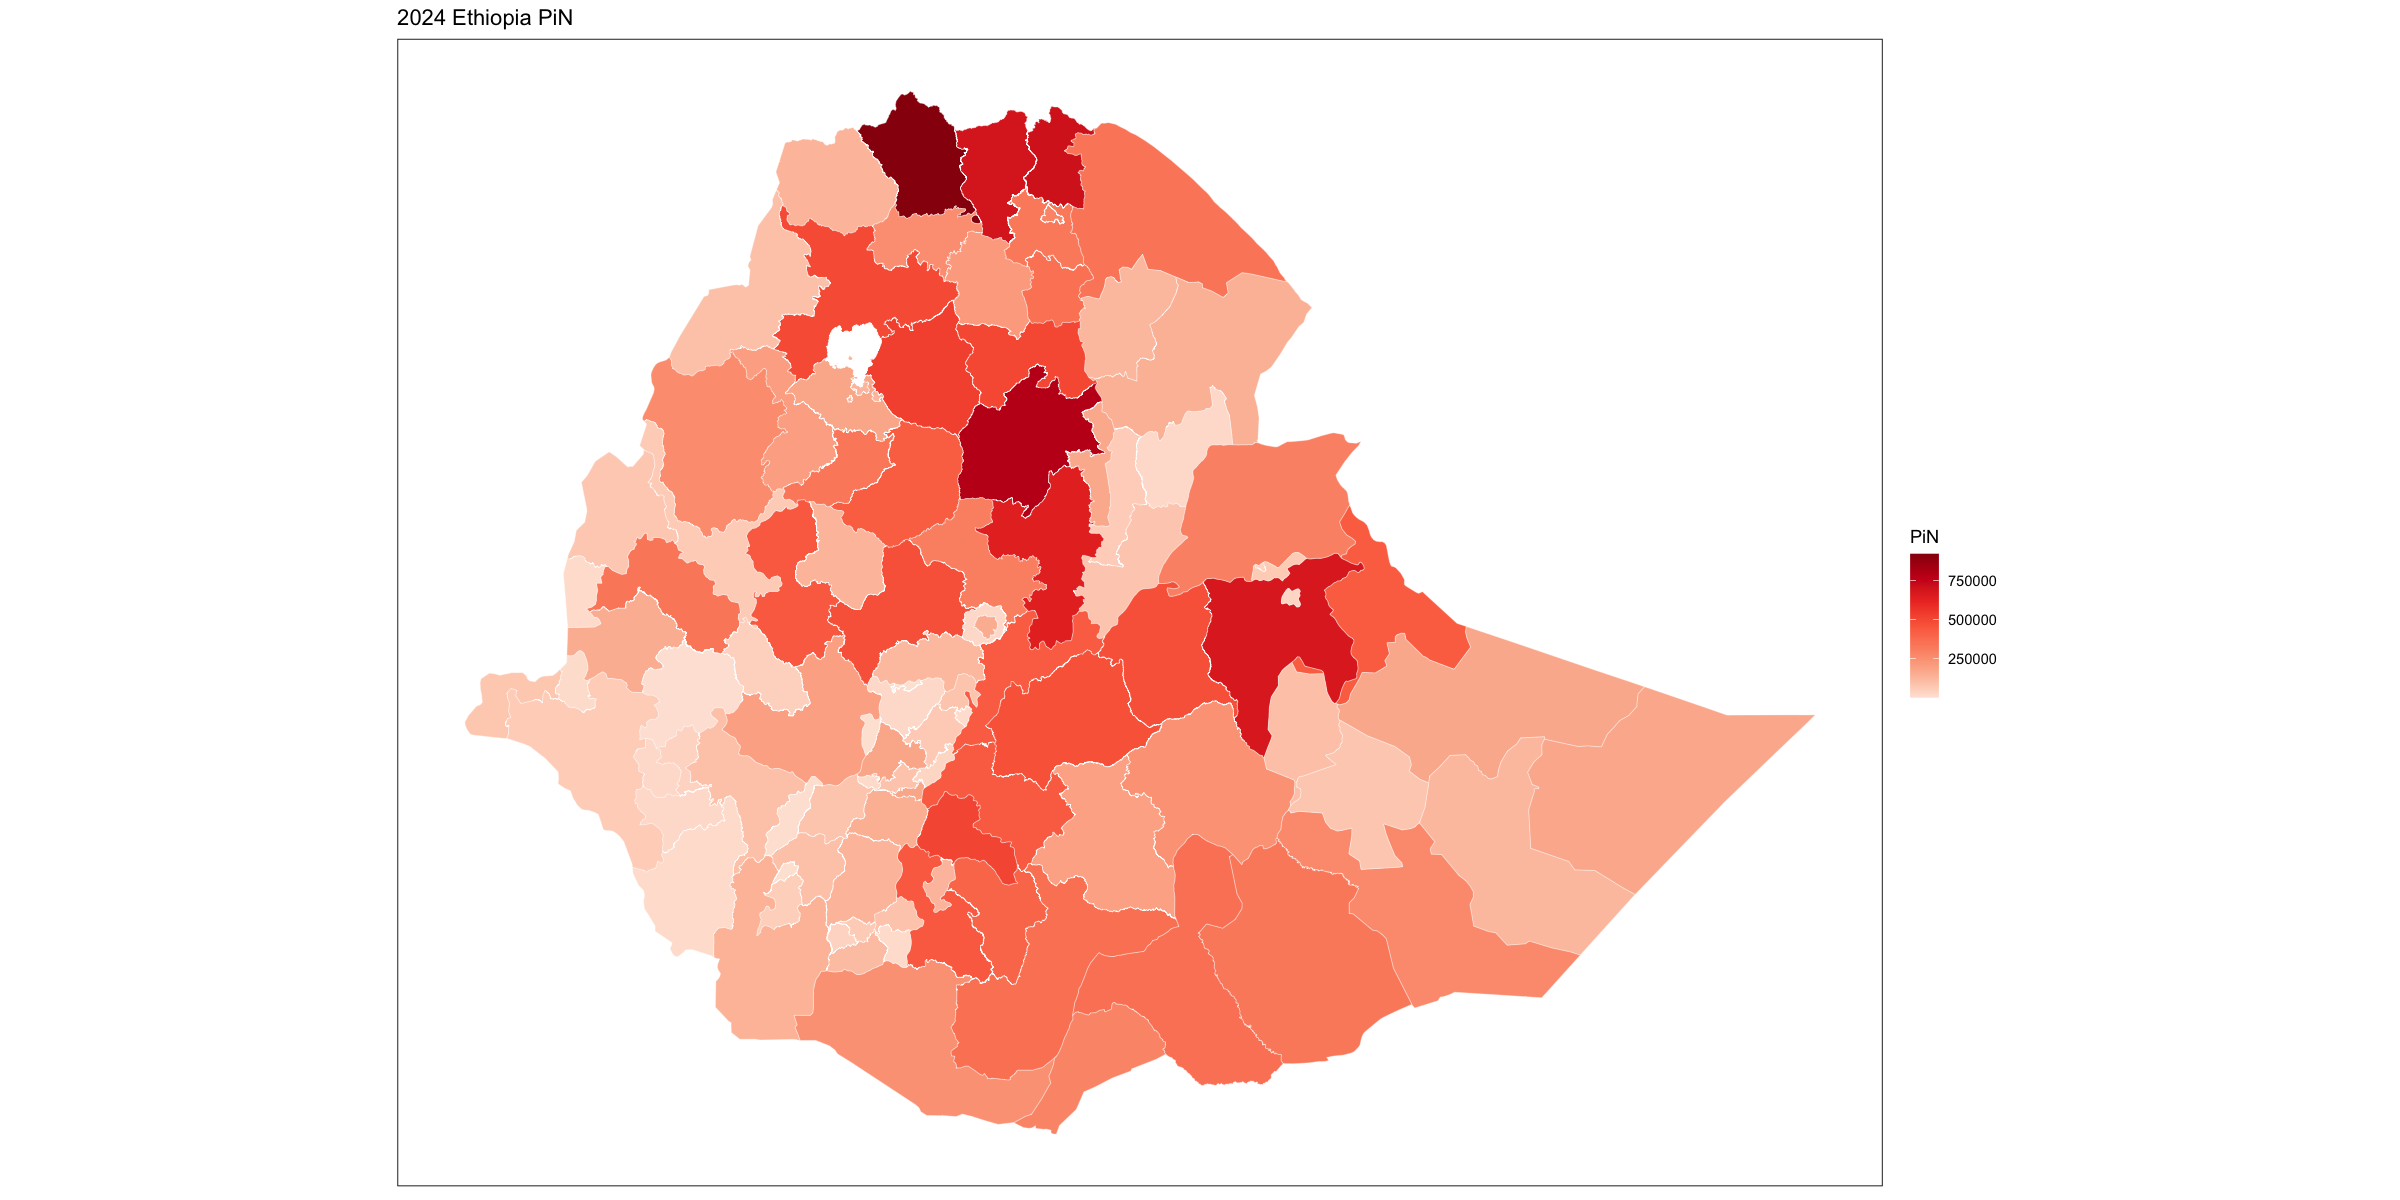

In [99]:
ggplot(data = gdf_adm2) +
  geom_sf(aes(fill = TotalPin), linewidth=0.1, color="white") +
  scale_fill_distiller(palette = "Reds", direction = 1) + 
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    panel.background = element_rect(fill = "white"),  # White background
    plot.background = element_rect(fill = "white", color = NA)  # White plot area
  ) + 
  labs(title = "2024 Ethiopia PiN",
       fill = "PiN")

## Targetting areas -- Zones that experience MAM and OND rains

In [100]:
# MAM and OND zones defined by FEWSNET
df_mam_ond <- read_csv(
    file.path(
        Sys.getenv("AA_DATA_DIR"),
        "public", "exploration", "eth", 
        "mam_ond_zones_fewsnet.csv"
    ),
    show_col_types=FALSE
)

# Also hard-code in some zones 
ond_zones <- list(
    "ET0508",
    "ET0806",
    "ET0808",
    "ET0411",
    "ET0412",
    "ET0810",
    "ET0511",
    "ET0807",
    "ET0507",
    "ET0421",
    "ET0410",
    "ET0504",
    "ET0502",
    "ET0802",
    "ET0414",
    "ET0503",
    "ET0809",
    "ET0505",
    "ET0509",
    "ET0510",
    "ET0506",
    "ET0812",
    "ET0415",
    "ET0422",
    "ET0408",
    "ET0417",
    "ET1600",
    "ET0811"
)

# Filter the gdf to only include the admin areas that experience ond/mam seasons
gdf_ond_mam <- gdf_adm2 %>%
    filter(
        admin2Pcode %in% df_mam_ond$admin2Pcode |
        admin2Pcode %in% ond_zones
    )

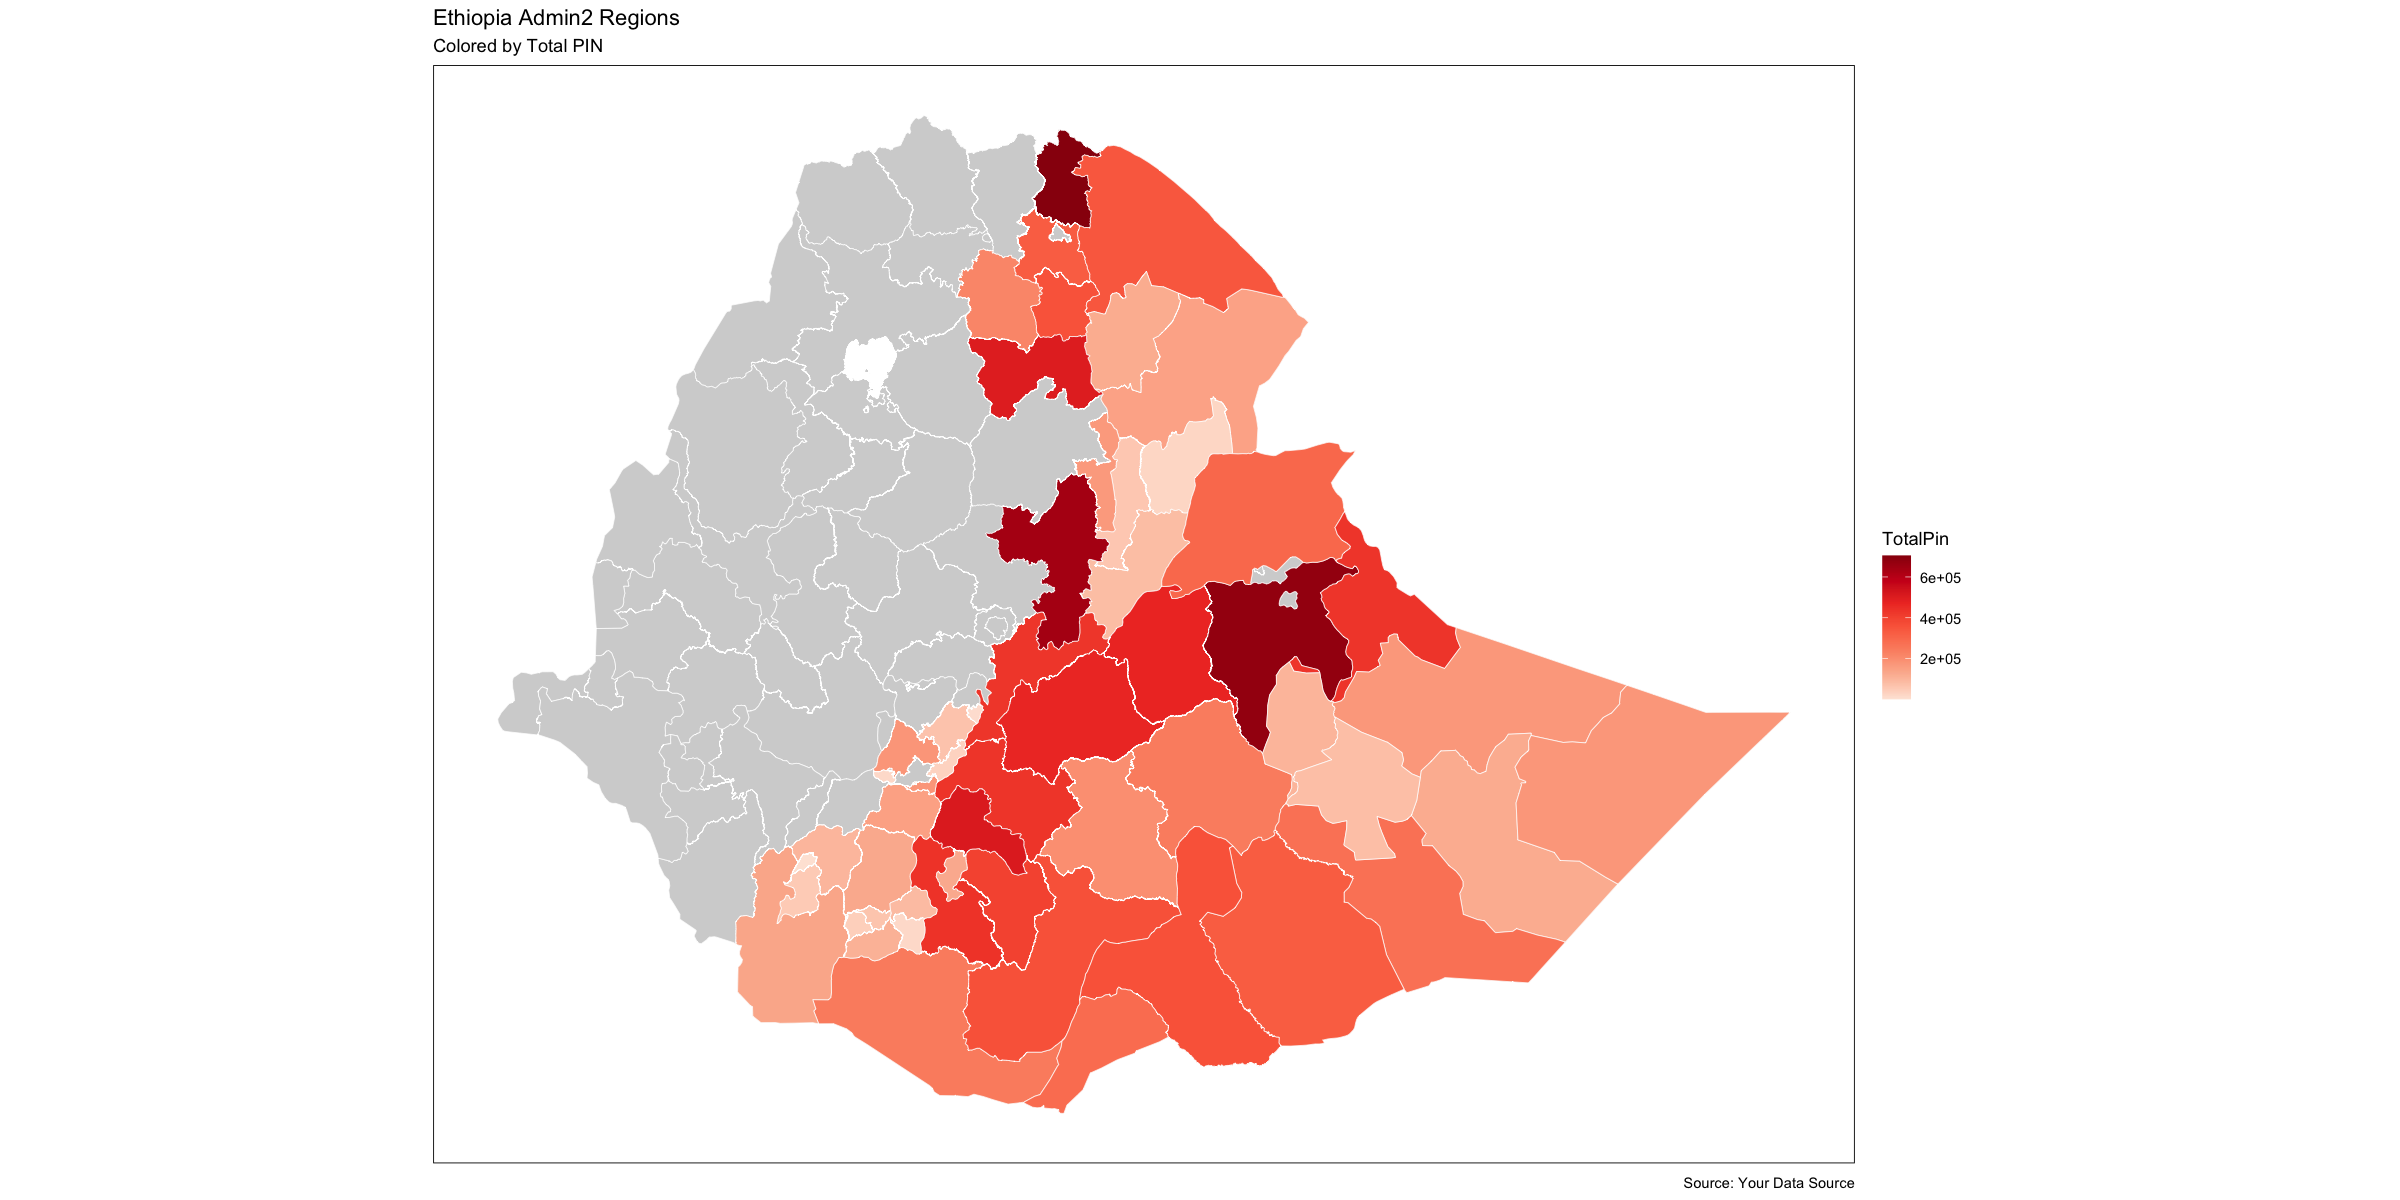

In [101]:
map <- ggplot() +
  # First layer: Grey basemap
  geom_sf(data = gdf_adm2, fill = "lightgrey", color = "white") +
  
  # Second layer: Colored admin2 regions
  geom_sf(data = gdf_ond_mam, aes(fill = TotalPin), color = "white") +
  
  # Color scale for the TotalPin values
  #scale_fill_viridis_c(option = "plasma", name = "Total PIN") +
    scale_fill_distiller(palette = "Reds", direction = 1) + 
  
  # Adjust the theme for a cleaner map look
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    axis.title = element_blank(),
    panel.background = element_rect(fill = "white"),
    plot.background = element_rect(fill = "white", color = NA)
  ) +
  
  # Add labels
  labs(title = "Ethiopia Admin2 Regions",
       subtitle = "Colored by Total PIN",
       caption = "Source: Your Data Source")

# Display the map
print(map)

## Processing rainfall data

In [26]:
df_imerg_filtered <- df_imerg %>%
    filter(
        pcode %in% df_mam_ond$admin2Pcode |
        pcode %in% ond_zones
    )

In [59]:
df_mam_by_zone <- df_imerg_filtered %>% 
    mutate(year = year(valid_date), month = month(valid_date)) %>%
    filter(month %in% c(3, 4, 5)) %>%
    group_by(pcode, year) %>% 
    summarise(total_rainfall_mam = sum(mean, na.rm=TRUE)) %>%
    ungroup() %>%
    arrange(pcode, year) %>%
    mutate(year = as.numeric(year)) %>%
    group_by(pcode) %>%
    mutate(
        tercile = ntile(total_rainfall_mam, 3),
        is_lower_tercile = tercile == 1
        ) %>%
    ungroup()

`summarise()` has grouped output by 'pcode'. You can override using the `.groups` argument.


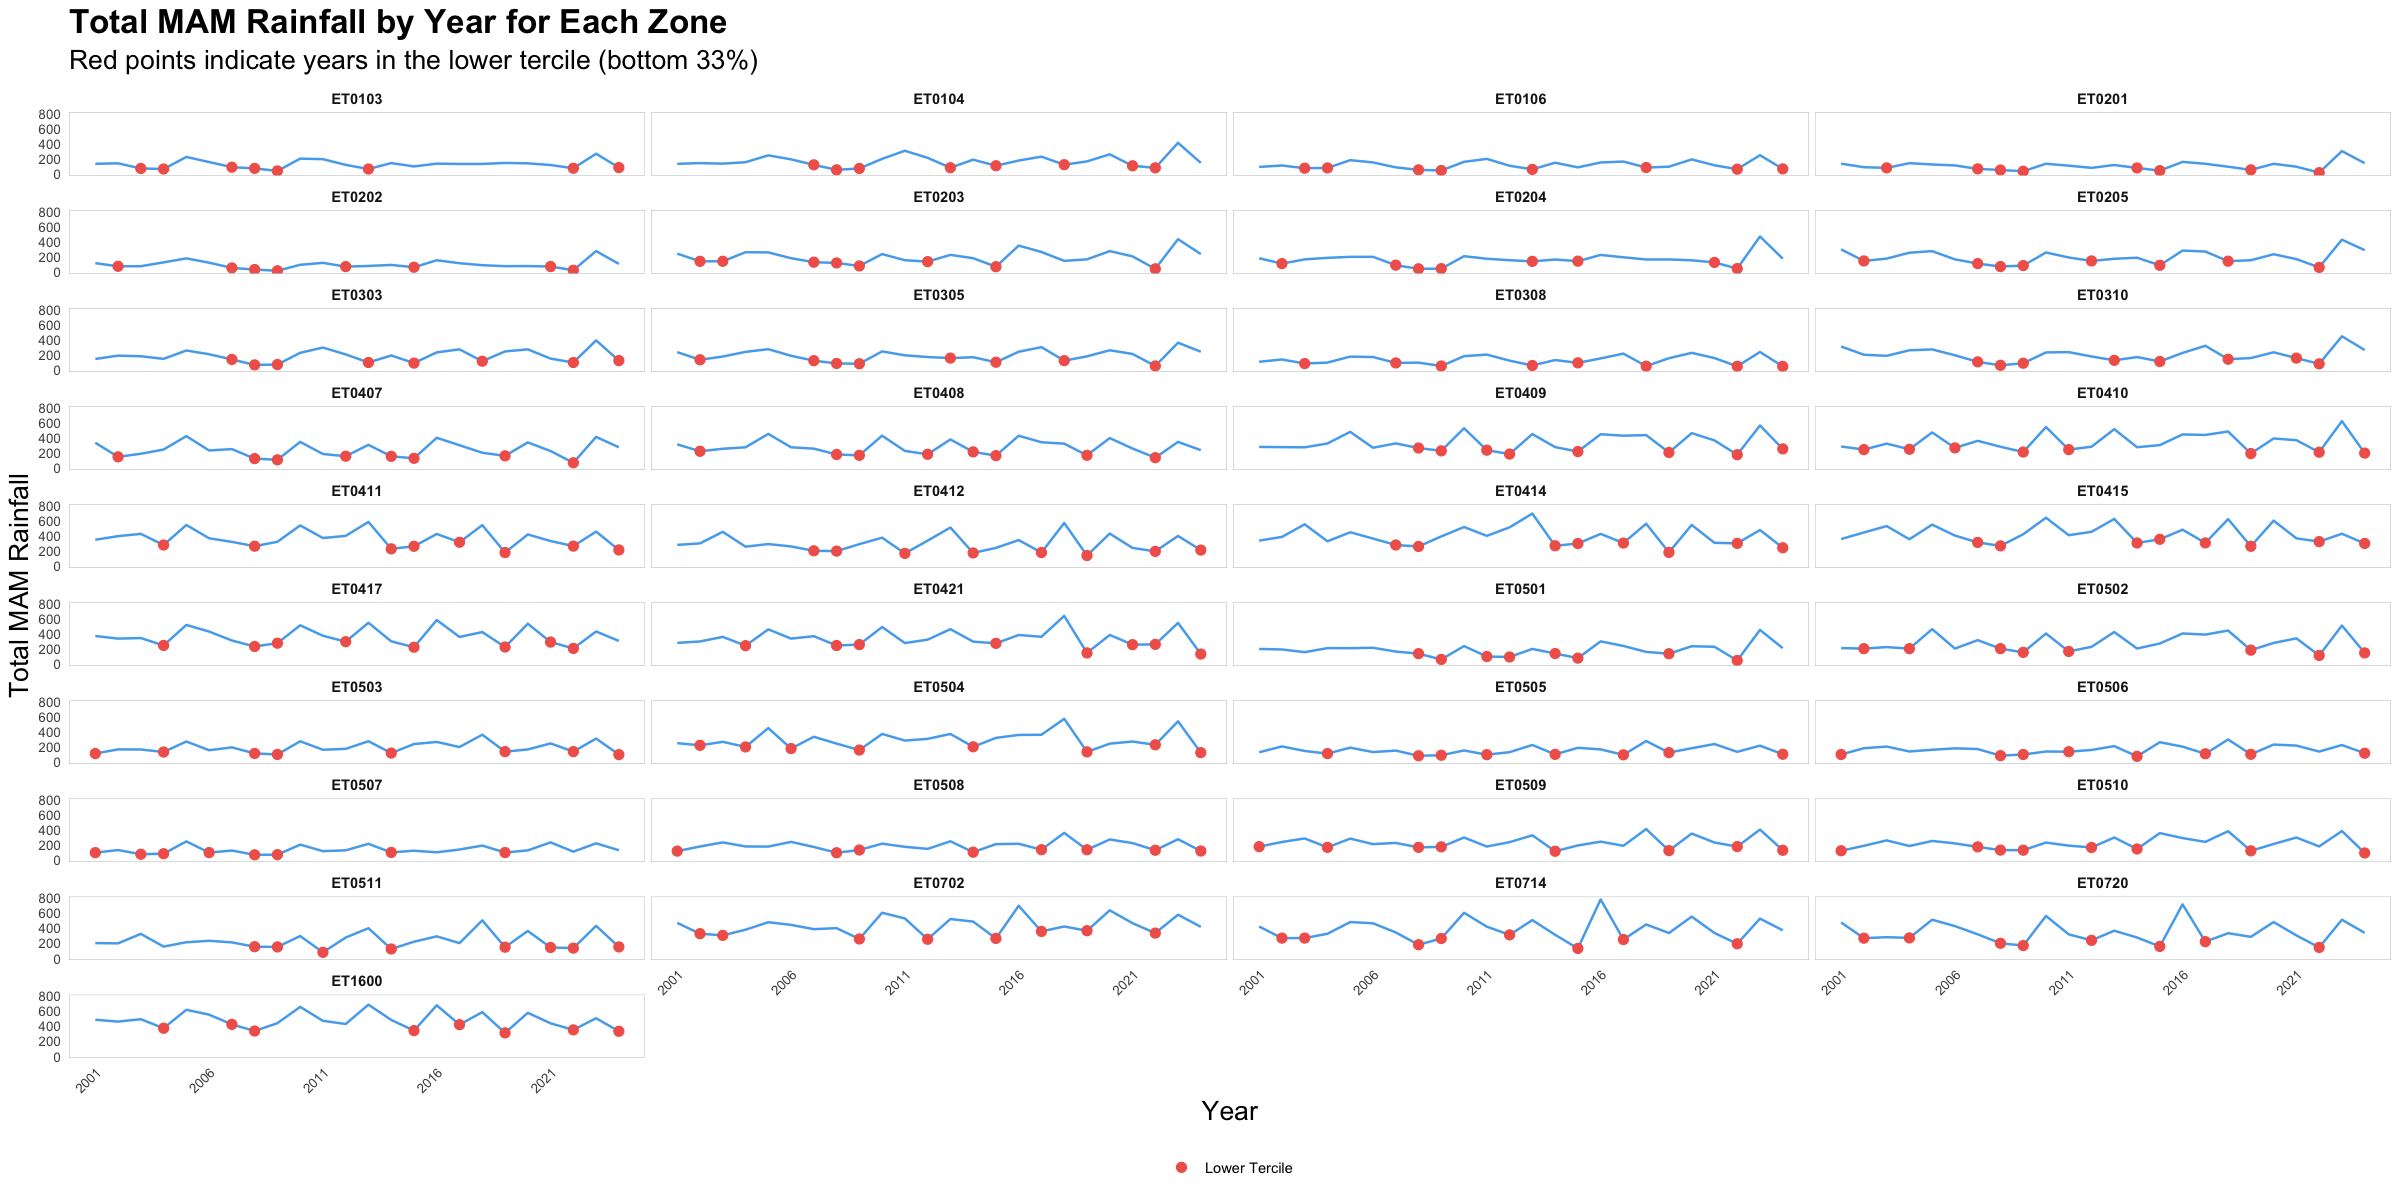

In [88]:
ggplot(df_mam_by_zone, aes(x = year, y = total_rainfall_mam, group = pcode)) +
  geom_line(color = "#55ACEE", size = 0.7) +
  geom_point(data = filter(df_mam_by_zone, is_lower_tercile), 
             aes(color = "Lower Tercile"), size = 2.5) +
  scale_color_manual(values = c("Lower Tercile" = "#F2645A")) +
  facet_wrap(~ pcode, scales = "fixed", ncol = 4) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    axis.text.y = element_text(size = 8),
    axis.title = element_text(size = 16),
    strip.text = element_text(face = "bold"),
    panel.spacing = unit(0.25, "lines"),
    axis.text.y.right = element_blank(),
    axis.ticks.y.right = element_blank(),
    axis.title.y.right = element_blank(),
    panel.grid = element_blank(),
    panel.border = element_rect(color = "grey", fill = NA, size = 0.25),
    legend.position = "bottom",
    plot.title = element_text(size = 20, face = "bold"),
    plot.subtitle = element_text(size = 16)
  ) +
  labs(
    title = "Total MAM Rainfall by Year for Each Zone",
    subtitle = "Red points indicate years in the lower tercile (bottom 33%)",
    x = "Year",
    y = "Total MAM Rainfall",
    color = NULL
  ) +
  scale_x_continuous(breaks = seq(min(df_mam_by_zone$year), max(df_mam_by_zone$year), by = 5))

## Joining PiN and total rainfall

In [127]:
gdf_pin <- gdf_ond_mam %>%
    select("admin2Pcode", "admin2Name_en", "TotalPin", "geometry")

In [131]:
gdf_merged <- df_mam_by_zone %>%
    left_join(gdf_pin, by = c("pcode" = "admin2Pcode")) %>%
    mutate(TotalPin = if_else(is_lower_tercile == FALSE, 0, TotalPin)) 

In [133]:
df_pin_mam <- gdf_merged %>% 
    group_by(year) %>% 
    summarise(total_pin = sum(TotalPin, na.rm=TRUE)) %>%
    ungroup() %>%
    arrange(year)

In [134]:
df_pin_mam

year,total_pin
<dbl>,<dbl>
2001,1376284.3
2002,3613206.6
2003,1847217.4
2004,4501708.9
2005,0.0
2006,947862.3
2007,4991520.6
2008,9868322.7
2009,9248611.5


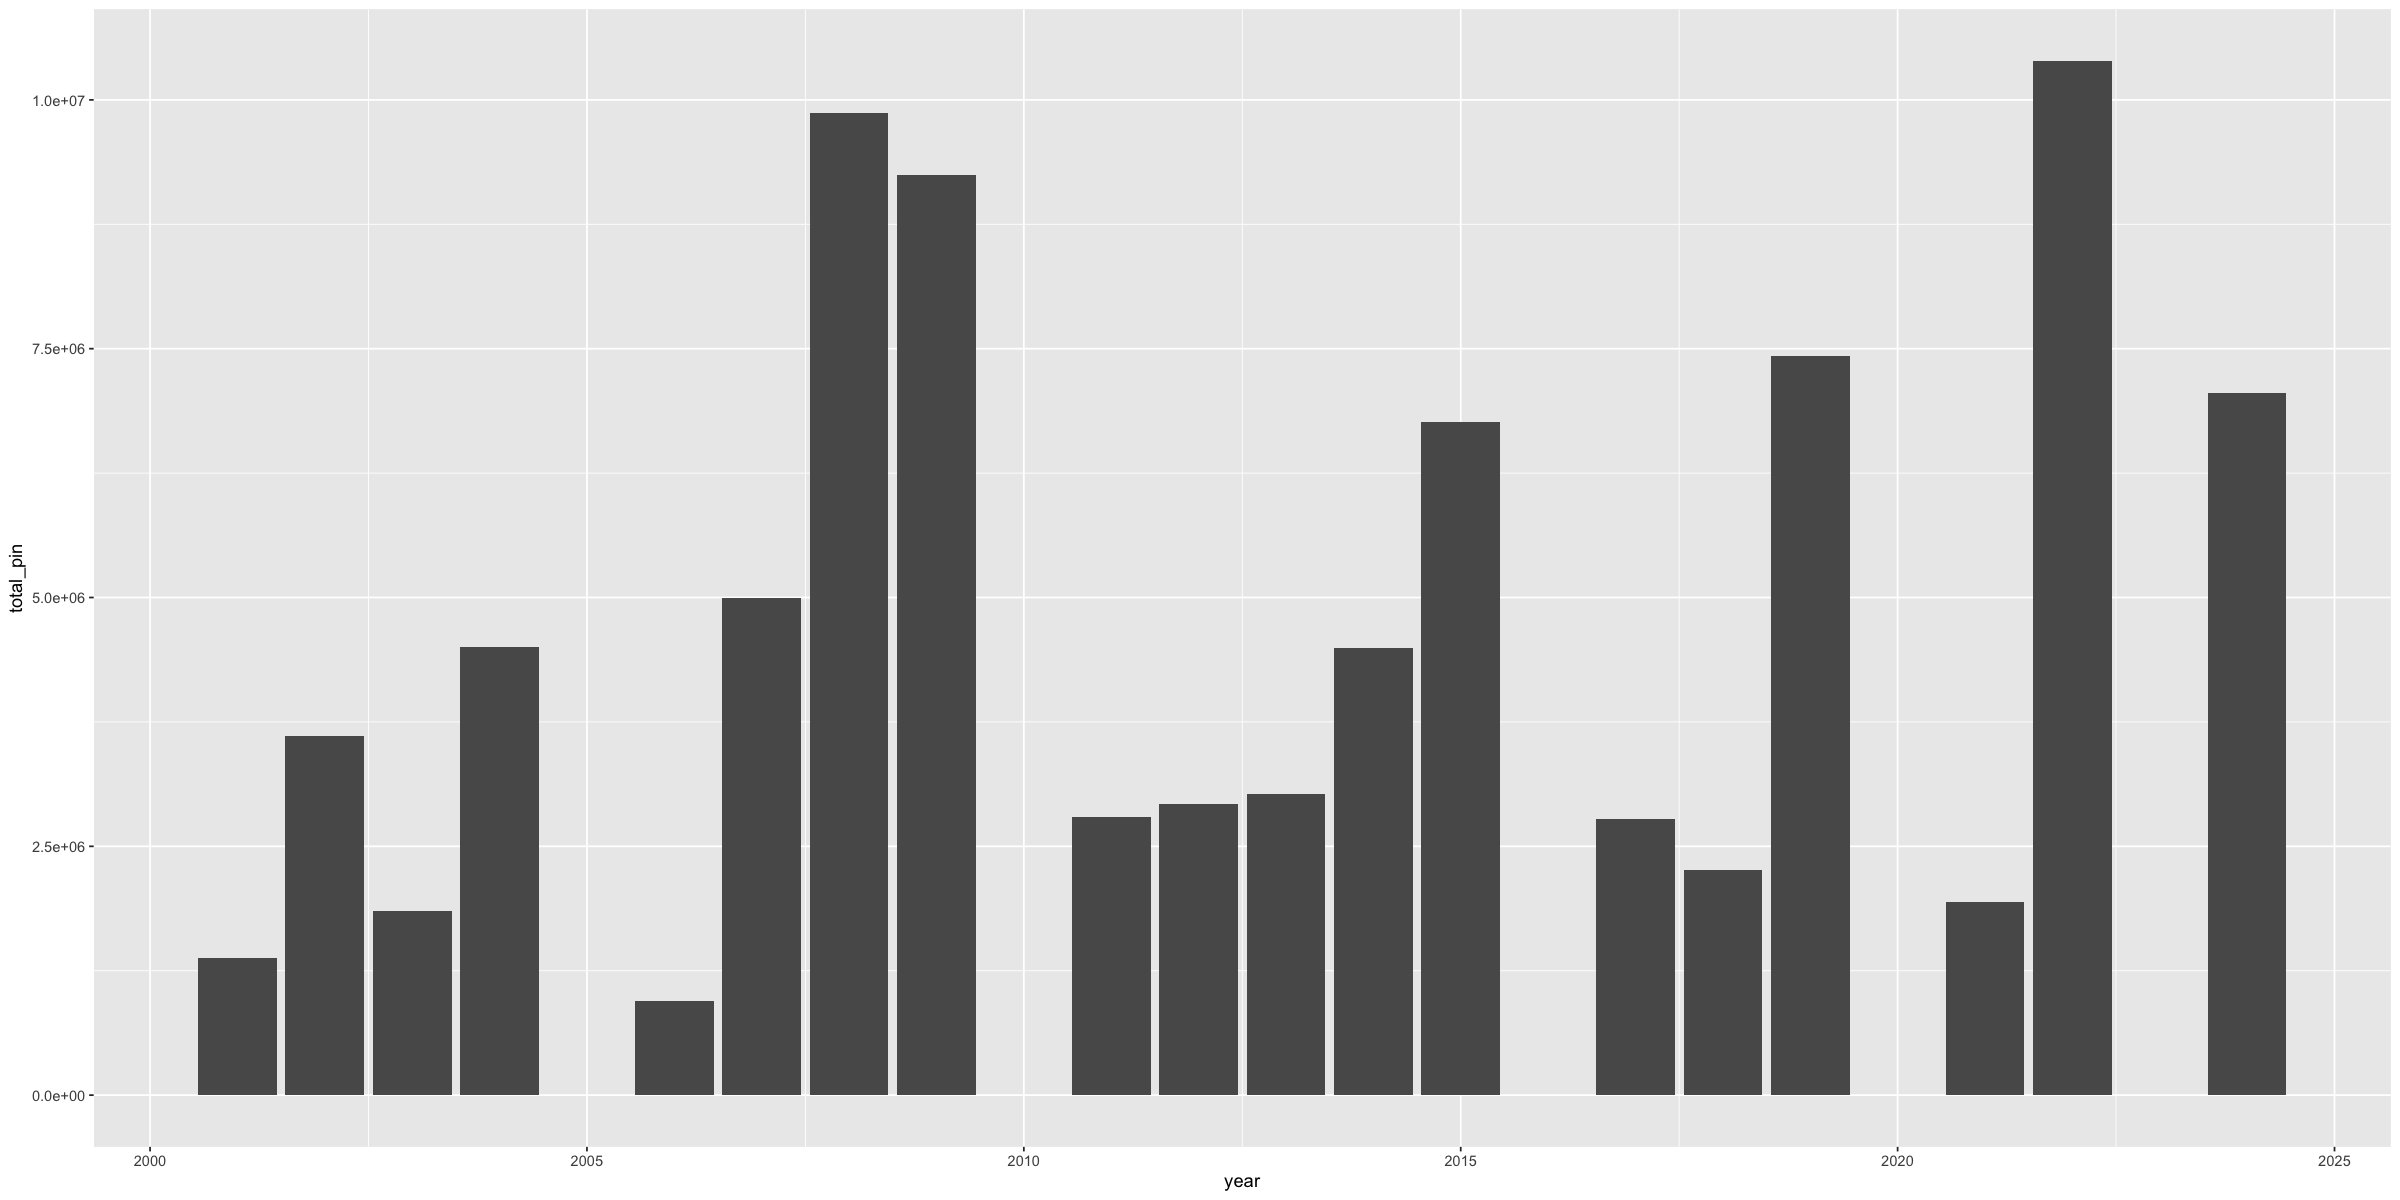

In [135]:
ggplot(df_pin_mam, aes(x=year, y=total_pin)) + 
  geom_bar(stat = "identity")